# Internal Standards Quality Control for BIND-473

## Phillip Wilmarth, OHSU

### January 3, 2019

---

## Large urine exosome project
This is a 3 x 20 TMT experiment done with 7 11-plex TMT kits. The 10th and 11th channels (131-N and 131-C tags) were used for the pooled internal standards according to the sample keeping records. We will verify that the record keeping was correct using an edited copy of the [auto_finder notebook](https://pwilmart.github.io/TMT_analysis_examples/auto_finder_PAW.html).

### Workflow steps
- load the large results file
- separate the TMT data from the seven 11-plexes
- run "find_best_pair" function for each plex

---

## Load R libraries

In [1]:
# library imports
library(tidyverse)
library(stringr)
library(limma)
library(psych)
library(Matrix)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘limma’ was built under R version 3.5.1”
Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



## Load the TMT data from the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git)
This can be either the grouped protein file or the labeled file (for reading by the IRS script). We have inspected the file using Excel and determined that the main table has 3675 rows (not counting the header row).

> I need to figure out how to read the data files without having to see how long they are beforehand...

In [2]:
# load the raw data
# the table starts in Row 5
# there are extra lines at the bottom - need to stop before the end
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_8.txt", 
                        skip = 4, n_max = 3675, guess_max = 3675)

# the "Filter" column flags contams and decoys
data_all <- filter(data_import, is.na(Filter))

# how big is the data frame?
print("loaded data dimensions:")
dim(data_import)

# check number of rows before and after filtering
print("Rows before and after filtering:")
cat(nrow(data_import), nrow(data_all))

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


[1] "loaded data dimensions:"


[1] 3675  119

[1] "Rows before and after filtering:"
3675 3507

### Extract the raw data for each TMT-plex
We need a data frame for each TMT-plex that we are checking. The function we will be calling assumes each column in the data frame is a TMT channel from one plex (samples labeled with one TMT kit will be referred to as a "plex").

In [3]:
# make a data frame for each TMT-plex (and drop zeros)
get_data <- function(df, substring) {
    # extracts PAW TMT columns containing a substring
    
    # df: data frame of PAW results
    # substring: a text substring that defines one TMT-plex
    
    # get the columns
    df <- df %>%
      select(starts_with("TotInt")) %>% 
      select(contains(substring))
    
    # drop rows with zeros
    df[apply(df, 1, function(row) all(row !=0 )), ] # return filtered frame
}

# get each experiment and set column names to something easy to parse
exp1_raw <- get_data(data_all, "_exp1")
exp2_raw <- get_data(data_all, "_exp2")
exp3_raw <- get_data(data_all, "_exp3")
exp4_raw <- get_data(data_all, "_exp4")
exp5_raw <- get_data(data_all, "_exp5")
exp6_raw <- get_data(data_all, "_exp6")
exp7_raw <- get_data(data_all, "_exp7")

## Function to make this checking easy 
The **find_best_pair** function will make an interquartile range (IQR) grid of standardized differences for all channels against all channels after sample loading normalization. The top-N smallest IQR values will be found, the associated pair indices determined, channel versus channel scatter plots made, and box plots of the IQRs generated. The next cell has the function definitions.

In [4]:
# automatically find closest channel pairs

SL_norm <- function(df, suffix, print_factors = TRUE) {
    # Normalizes each channel's sum to the average grand total
        # df: data frame of TMT data (one column for each channel)
        # suffix: a text string to append to 1-to-n numbers for column names
        # print_factors: logical to control printing
    
    # compute norm factors and scale columns
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # simplify column names
    colnames(df_sl) <- str_c(as.character(1:ncol(df)), suffix)
    
    # print the normalization factors for QC check
    if (print_factors == TRUE) {
        cat("\nNormalization Factors: ", suffix, "\n ")
        cat(sprintf("%s - %0.3f\n", colnames(df), norm_facs))
    }
    
    df_sl # return normalized data
}

diff <- function(df, x, y) {
    # computes a standardized difference between two vectors
        # df: data frame that contains x and y
        # x: index of first column
        # y: index of second column
    
    # compute the difference and set the column name
    diff <- 100 * abs(df[x] - df[y]) / rowMeans(df[c(x, y)])
    colnames(diff) <- sprintf("%d_%d", x, y)
    
    diff # return difference vector
}

iqr_grid <- function(df, print_grid = TRUE) {
    # computes an NxN grid of interquartile ranges of diffs    
         # df: a data frame of TMT data
         # print_grid: logical to control printing
    
    # make an empty matrix ncol-by-ncol
    iqrs  <- matrix(0.0, ncol(df), ncol(df))
    
    # populate an upper diagonal "diff" matrix
    for (i in 1:ncol(df)) {
        for (j in (i+1):ncol(df)) {
            if (j > ncol(df)) {
                break
            }
            iqrs[i, j] <- IQR(diff(df, i, j)[[1]])
        }
    }
    
    # print the grid
    if( print_grid == TRUE) {
        cat("\nInterquartile range grid:\n")
        print(round(iqrs, 2))
    }
    
    iqrs # return the iqr grid
}

find_best_pair <- function(df, nmax, suffix, title) {
    # finds channel pairs having the smallest standardized differences    
        # df: data frame with TMT channels
        # nmax: how many channels/pairs to check
        # suffix: suffix to add to channel labels
        # title: title string to use in plots
    
    # first do SL normalization
    df_sl <- SL_norm(df, suffix)
    
    # compute the ird grid
    iqrs <- iqr_grid(df_sl)
    
    # find the nmax number of smallest IQR values
    # from https://stackoverflow.com/questions/38664241/ranking-and-counting-matrix-elements-in-r
    iqrs_long <- summary(Matrix(iqrs, sparse = TRUE))
    iqrs_ordered <- iqrs_long[order(-iqrs_long[, 3], decreasing = TRUE),]
    candidates <- iqrs_ordered[1, 1] # starting vector of channels
    for (row in 1:nrow(iqrs_long)){
        candidates <- c(candidates, iqrs_ordered[row, 1])
        candidates <- c(candidates, iqrs_ordered[row, 2])
    }
    
    # get the set of indexes and print the best pairs
    for (pair in 1:nmax) {
        top_n <- sort(unique(candidates)[1:nmax])
        i <- iqrs_ordered[pair, 1]
        j <- iqrs_ordered[pair, 2]
        cat(sprintf("\nPair #%d: (%d, %d) => %0.2f", pair, i, j, iqrs[i, j]))
    }
    
    # make the box plots for the top-n pairs
    distributions <- list()
    for (row in 1:nmax){
        distributions[[row]] <- diff(df_sl, iqrs_ordered[row, 1], iqrs_ordered[row, 2])
    }
    boxplot(do.call(cbind, distributions), main = title)
    
    # multi-panel scatter plots for the top-n channels
    cat(pairs.panels(log10(df_sl[top_n]), lm = TRUE, main = title))
}

# Find the standard channel pair for the first plex


Normalization Factors:  _Exp1 
 TotInt_126C_Exp1 - 1.098
 TotInt_127N_Exp1 - 0.723
 TotInt_127C_Exp1 - 0.869
 TotInt_128N_Exp1 - 0.846
 TotInt_128C_Exp1 - 0.705
 TotInt_129N_Exp1 - 1.138
 TotInt_129C_Exp1 - 1.267
 TotInt_130N_Exp1 - 1.550
 TotInt_130C_Exp1 - 2.557
 TotInt_131N_Exp1 - 0.893
 TotInt_131C_Exp1 - 0.884

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 51.09 54.76 58.71 63.89 57.61 50.00 74.58 60.14 48.02 49.68
 [2,]    0  0.00 45.90 54.42 46.60 60.90 53.72 75.55 66.10 47.56 45.90
 [3,]    0  0.00  0.00 54.86 48.05 61.92 60.69 72.99 61.84 36.66 37.38
 [4,]    0  0.00  0.00  0.00 54.04 45.86 72.54 51.23 55.35 40.12 40.01
 [5,]    0  0.00  0.00  0.00  0.00 74.77 64.32 77.39 67.13 43.11 42.86
 [6,]    0  0.00  0.00  0.00  0.00  0.00 72.73 45.29 53.39 49.83 51.79
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 86.78 68.74 64.03 63.33
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 51.60 58.58 60.57
 [9,]    0  0.00

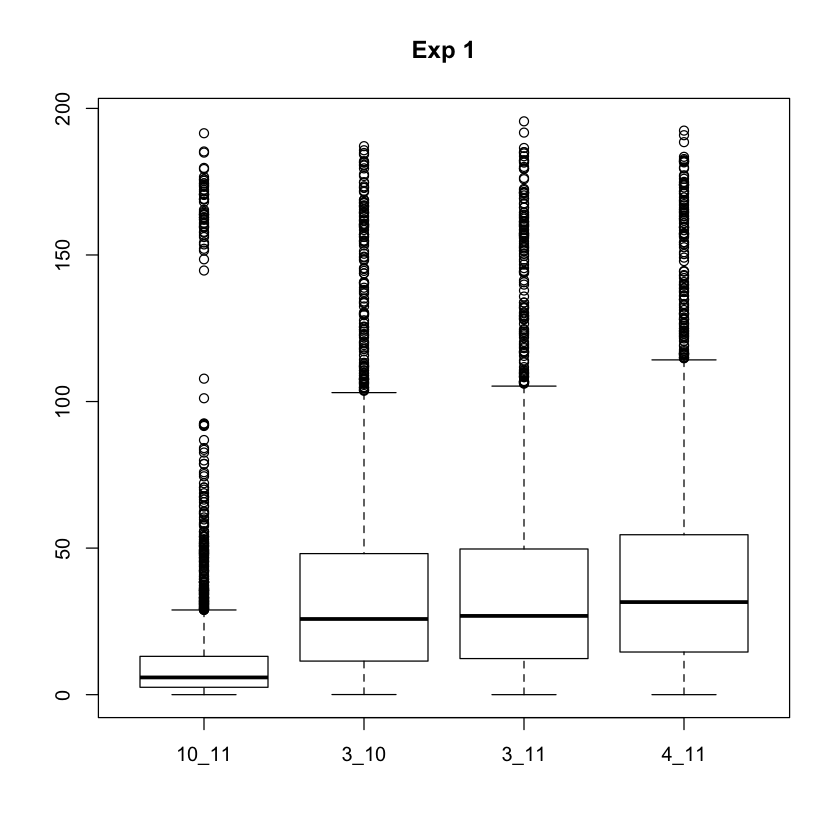

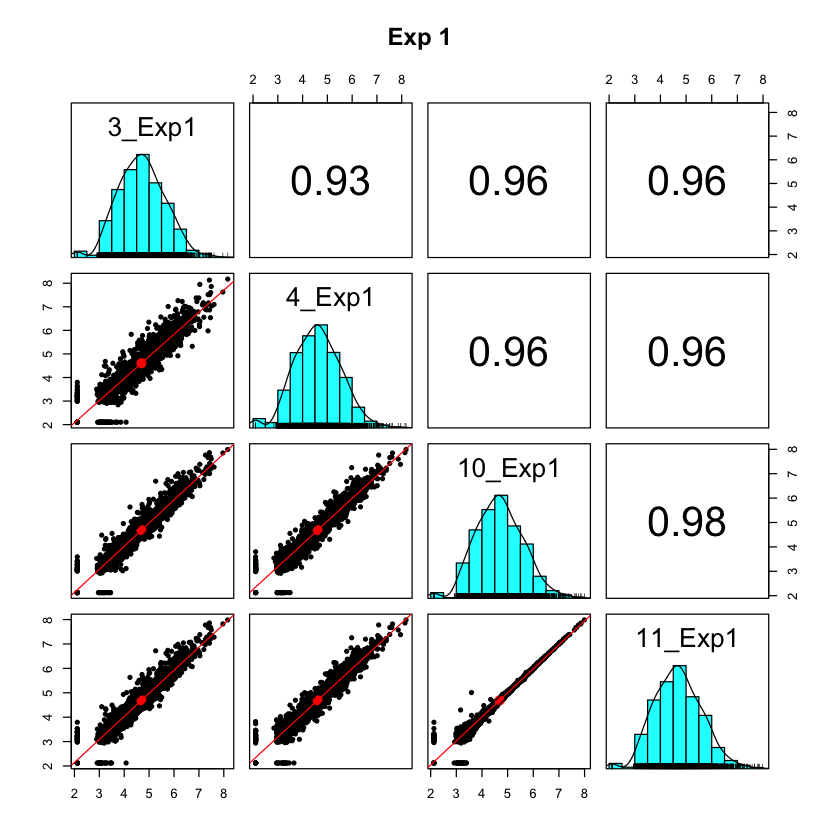

In [5]:
# nmax is how many top pairs to consider (3 or 4 are recommended values)
top_n <- 4

# find the standards in experiment 1
find_best_pair(exp1_raw, top_n, "_Exp1", "Exp 1")

## Check the other 6 plexes


Normalization Factors:  _Exp2 
 TotInt_126C_Exp2 - 0.913
 TotInt_127N_Exp2 - 0.733
 TotInt_127C_Exp2 - 0.862
 TotInt_128N_Exp2 - 1.164
 TotInt_128C_Exp2 - 0.870
 TotInt_129N_Exp2 - 1.497
 TotInt_129C_Exp2 - 1.015
 TotInt_130N_Exp2 - 1.208
 TotInt_130C_Exp2 - 0.993
 TotInt_131N_Exp2 - 1.058
 TotInt_131C_Exp2 - 1.065

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 77.26 68.92 64.02 62.59 64.19 65.77 68.43 61.38 60.73 63.09
 [2,]    0  0.00 48.64 62.67 48.76 79.47 57.17 61.94 48.13 47.01 48.38
 [3,]    0  0.00  0.00 46.32 40.78 63.60 42.14 53.10 40.74 41.04 42.01
 [4,]    0  0.00  0.00  0.00 42.87 47.20 44.77 53.22 41.79 43.03 41.47
 [5,]    0  0.00  0.00  0.00  0.00 60.75 38.31 57.48 36.82 36.62 36.48
 [6,]    0  0.00  0.00  0.00  0.00  0.00 50.00 53.31 53.91 55.35 53.26
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 46.84 36.06 37.06 37.73
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 40.65 40.53 41.29
 [9,]    0  0.00

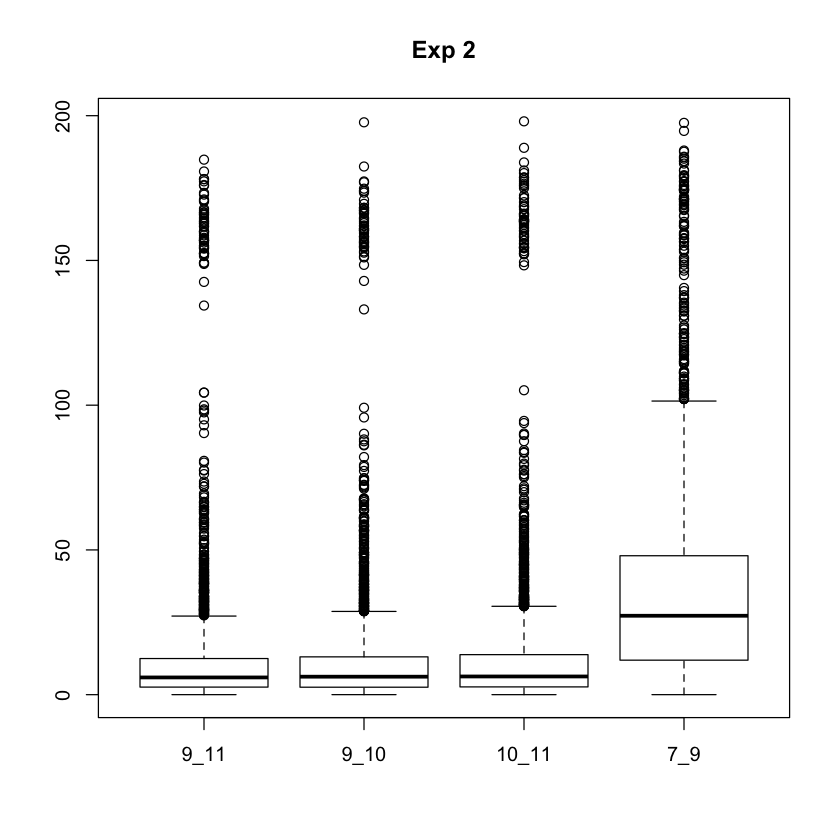

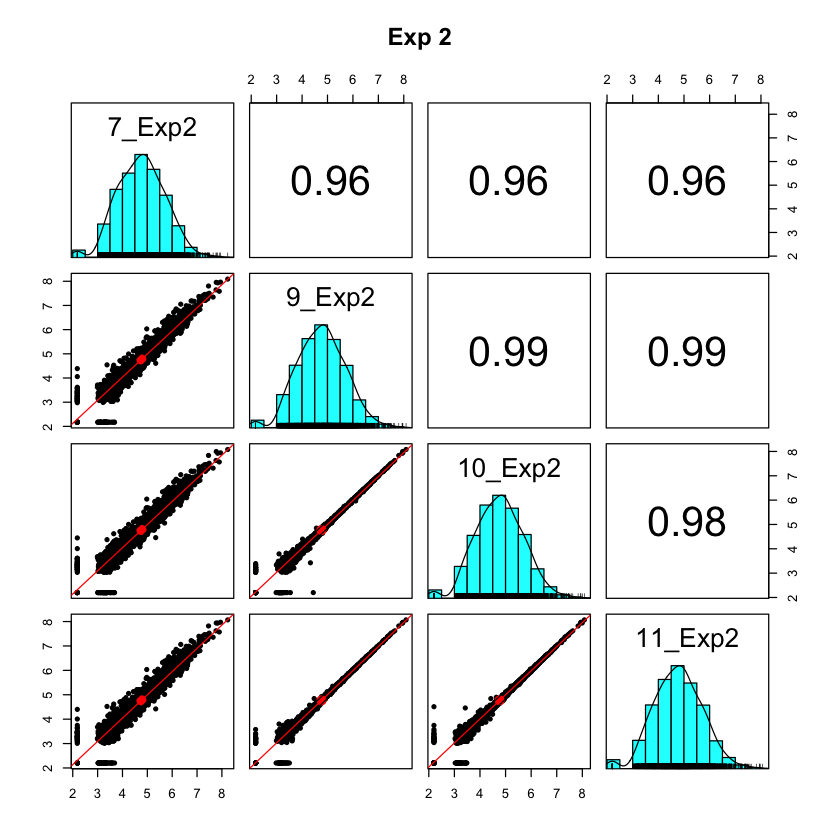

In [6]:
# experiment 2
find_best_pair(exp2_raw, top_n, "_Exp2", "Exp 2")

## What is happening?

This experiment has an extra pooled channel in 3 of the 7 plexes. The pooled channels are generally in channels 10 and 11 in all seven plexes. In experiments 2, 4, and 6, there is an extra channel of the standard in channel 9 (130-C tag).


Normalization Factors:  _Exp3 
 TotInt_126C_Exp3 - 0.787
 TotInt_127N_Exp3 - 1.152
 TotInt_127C_Exp3 - 0.959
 TotInt_128N_Exp3 - 1.005
 TotInt_128C_Exp3 - 0.961
 TotInt_129N_Exp3 - 0.880
 TotInt_129C_Exp3 - 1.000
 TotInt_130N_Exp3 - 1.475
 TotInt_130C_Exp3 - 1.043
 TotInt_131N_Exp3 - 1.022
 TotInt_131C_Exp3 - 0.970

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 60.08 59.04 48.21 45.81 42.82 51.96 54.39 60.93 36.92 37.48
 [2,]    0  0.00 65.48 55.69 54.54 68.15 62.18 68.78 64.50 56.93 58.11
 [3,]    0  0.00  0.00 59.98 65.64 66.87 64.55 67.62 79.45 53.47 51.90
 [4,]    0  0.00  0.00  0.00 53.61 53.05 54.46 57.22 60.91 42.50 41.98
 [5,]    0  0.00  0.00  0.00  0.00 62.70 42.27 54.54 48.47 40.65 41.73
 [6,]    0  0.00  0.00  0.00  0.00  0.00 60.93 59.05 65.46 42.35 42.04
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 43.42 55.76 43.27 44.03
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 60.00 44.07 46.40
 [9,]    0  0.00

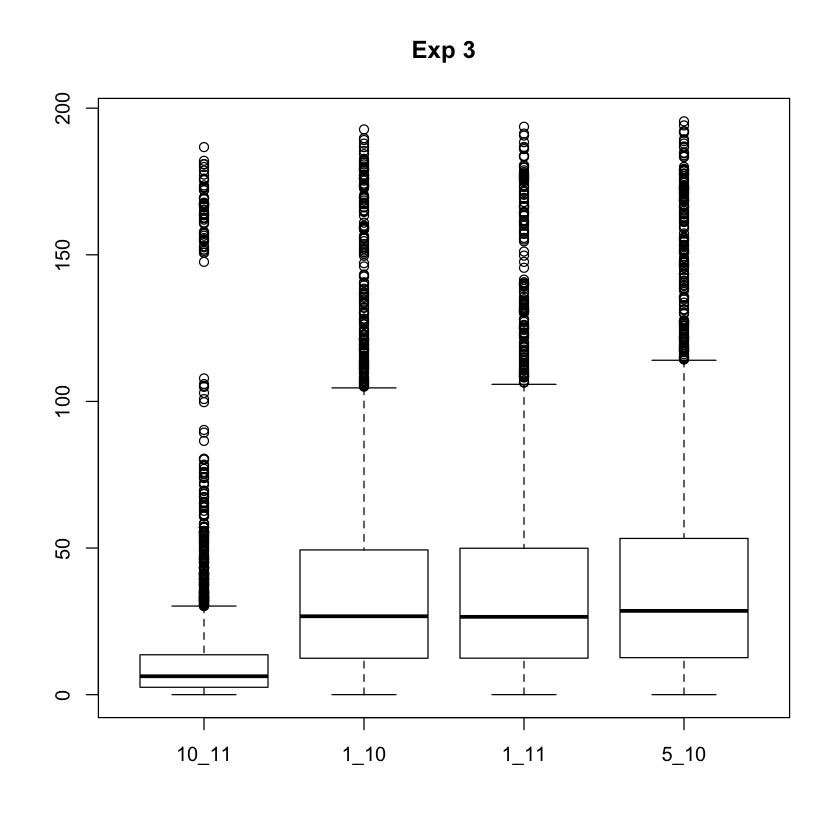

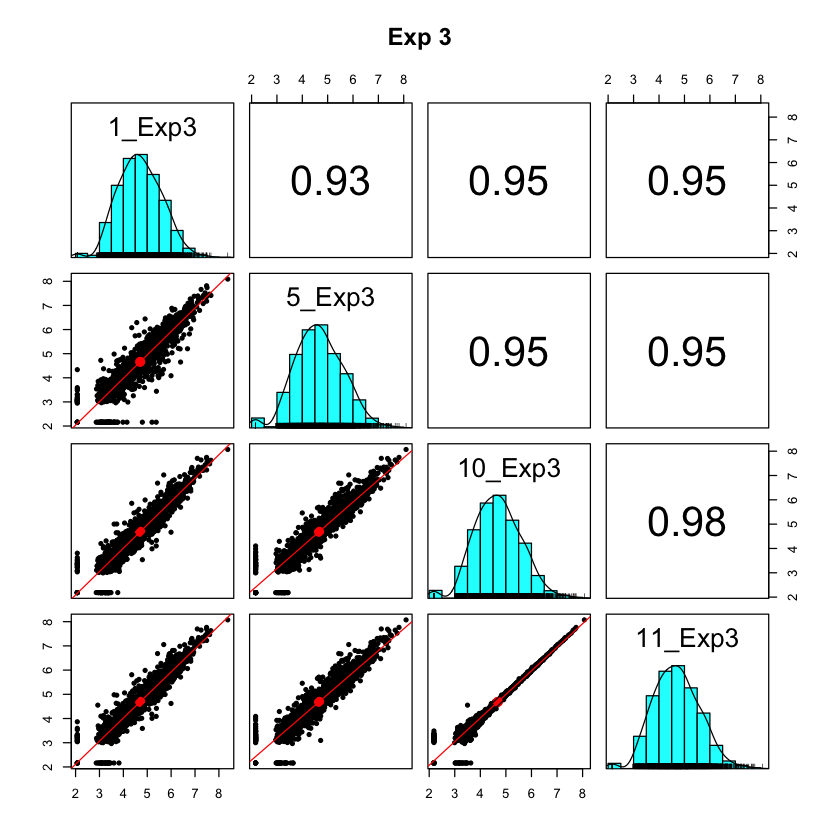

In [7]:
# experiment 3
find_best_pair(exp3_raw, top_n, "_Exp3", "Exp 3")


Normalization Factors:  _Exp4 
 TotInt_126C_Exp4 - 0.908
 TotInt_127N_Exp4 - 1.463
 TotInt_127C_Exp4 - 0.935
 TotInt_128N_Exp4 - 1.065
 TotInt_128C_Exp4 - 0.706
 TotInt_129N_Exp4 - 1.084
 TotInt_129C_Exp4 - 0.881
 TotInt_130N_Exp4 - 0.967
 TotInt_130C_Exp4 - 1.024
 TotInt_131N_Exp4 - 1.102
 TotInt_131C_Exp4 - 1.227

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 73.18 57.65 63.08 50.70 58.29 48.05 61.17 51.75 50.11 51.98
 [2,]    0  0.00 82.15 52.15 72.67 57.01 57.41 55.55 50.31 50.81 50.66
 [3,]    0  0.00  0.00 77.84 55.19 67.58 65.60 77.61 67.73 68.53 69.91
 [4,]    0  0.00  0.00  0.00 60.39 48.62 49.84 44.48 39.35 39.14 39.32
 [5,]    0  0.00  0.00  0.00  0.00 59.44 51.82 61.83 46.96 46.72 47.49
 [6,]    0  0.00  0.00  0.00  0.00  0.00 50.26 54.83 42.28 43.20 44.60
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 51.86 36.42 37.92 38.87
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 40.08 38.77 40.83
 [9,]    0  0.00

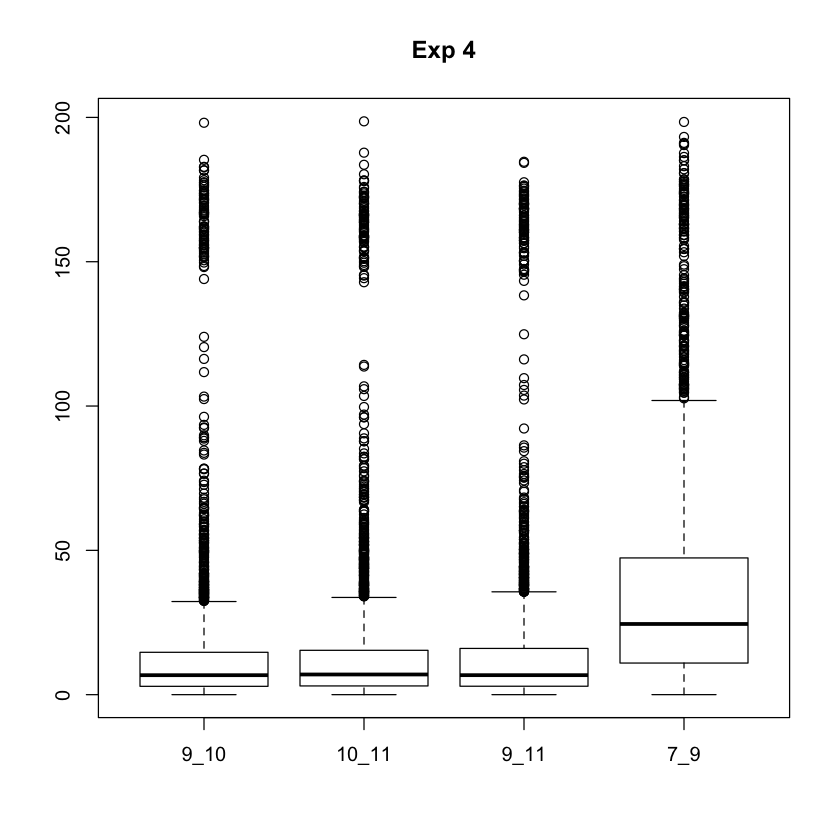

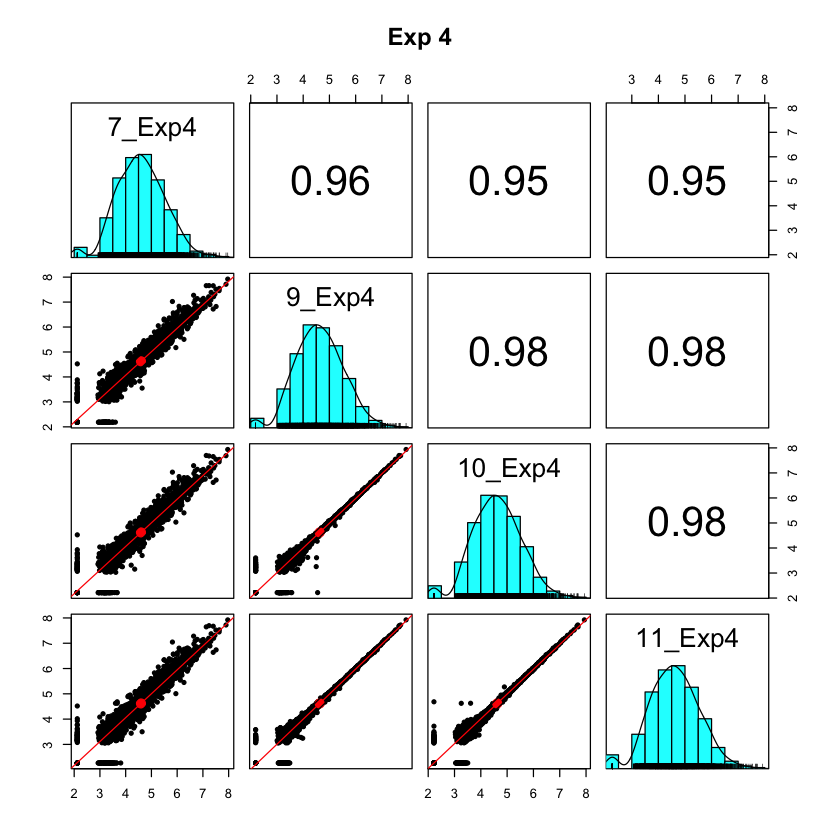

In [8]:
# Experiment 4
find_best_pair(exp4_raw, top_n, "_Exp4", "Exp 4")


Normalization Factors:  _Exp5 
 TotInt_126C_Exp5 - 0.894
 TotInt_127N_Exp5 - 1.157
 TotInt_127C_Exp5 - 0.946
 TotInt_128N_Exp5 - 1.124
 TotInt_128C_Exp5 - 1.324
 TotInt_129N_Exp5 - 0.736
 TotInt_129C_Exp5 - 0.735
 TotInt_130N_Exp5 - 1.159
 TotInt_130C_Exp5 - 1.025
 TotInt_131N_Exp5 - 1.220
 TotInt_131C_Exp5 - 1.065

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 69.91 56.71 76.11 64.92 65.63 72.67 70.79 83.85 50.89 51.24
 [2,]    0  0.00 64.76 48.33 58.89 63.63 62.34 87.22 82.24 48.64 47.65
 [3,]    0  0.00  0.00 66.07 59.72 83.04 63.49 73.12 85.07 52.47 53.05
 [4,]    0  0.00  0.00  0.00 60.42 62.16 66.50 81.55 80.74 50.38 50.27
 [5,]    0  0.00  0.00  0.00  0.00 75.11 64.24 84.52 86.25 49.77 48.73
 [6,]    0  0.00  0.00  0.00  0.00  0.00 77.65 72.14 89.83 54.54 54.39
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 63.50 84.12 51.51 53.98
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 88.64 64.59 65.30
 [9,]    0  0.00

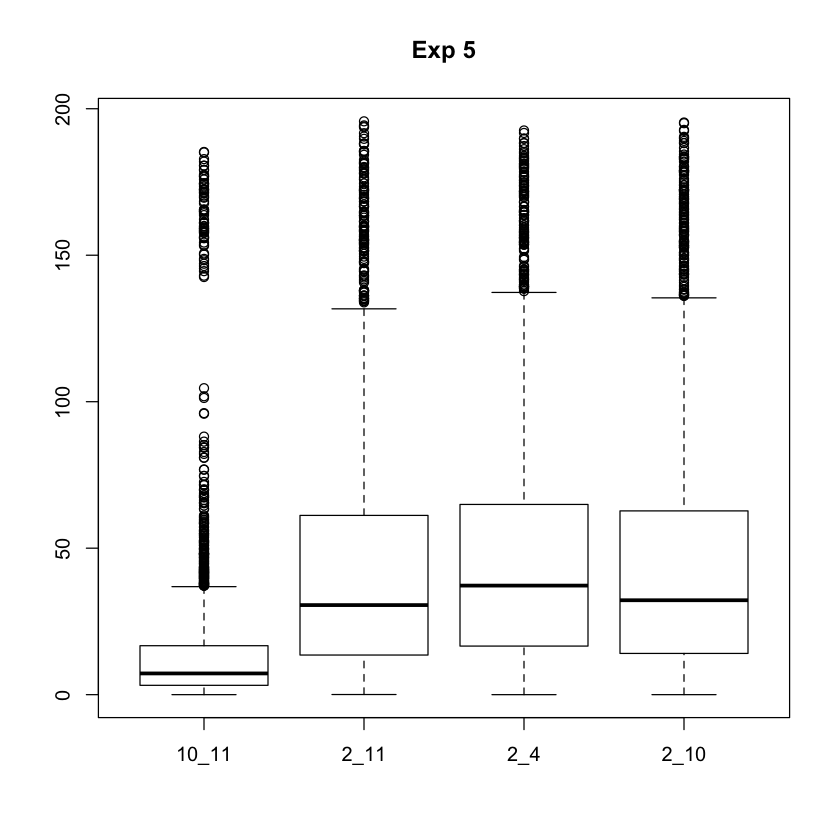

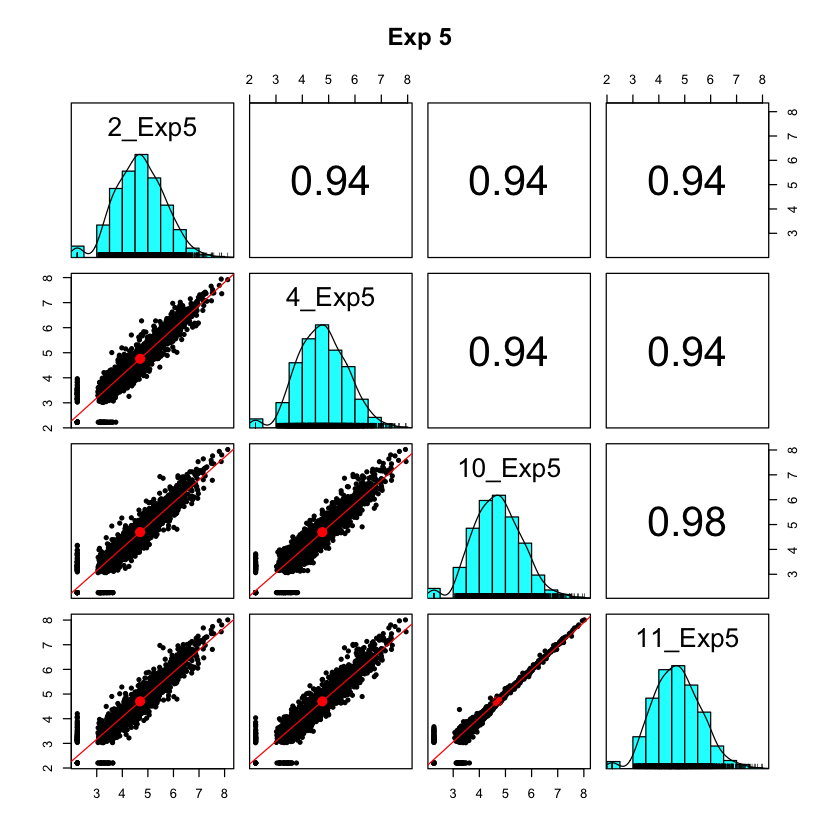

In [9]:
# Experiment 5
find_best_pair(exp5_raw, top_n, "_Exp5", "Exp 5")


Normalization Factors:  _Exp6 
 TotInt_126C_Exp6 - 0.906
 TotInt_127N_Exp6 - 0.690
 TotInt_127C_Exp6 - 1.073
 TotInt_128N_Exp6 - 0.828
 TotInt_128C_Exp6 - 1.866
 TotInt_129N_Exp6 - 1.132
 TotInt_129C_Exp6 - 1.021
 TotInt_130N_Exp6 - 0.997
 TotInt_130C_Exp6 - 1.083
 TotInt_131N_Exp6 - 1.049
 TotInt_131C_Exp6 - 0.969

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 76.17 65.90 89.30 60.66 66.39 70.00 45.59 60.33 59.97 61.88
 [2,]    0  0.00 70.04 66.87 85.74 70.56 79.48 71.23 51.90 53.32 51.57
 [3,]    0  0.00  0.00 79.32 57.33 64.06 73.24 57.04 49.88 49.49 48.53
 [4,]    0  0.00  0.00  0.00 83.60 63.26 72.98 79.42 61.70 61.55 61.46
 [5,]    0  0.00  0.00  0.00  0.00 58.54 63.58 45.55 57.40 58.17 58.70
 [6,]    0  0.00  0.00  0.00  0.00  0.00 62.39 49.12 49.69 48.86 51.14
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 59.65 61.65 61.09 59.66
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 44.71 45.55 45.51
 [9,]    0  0.00

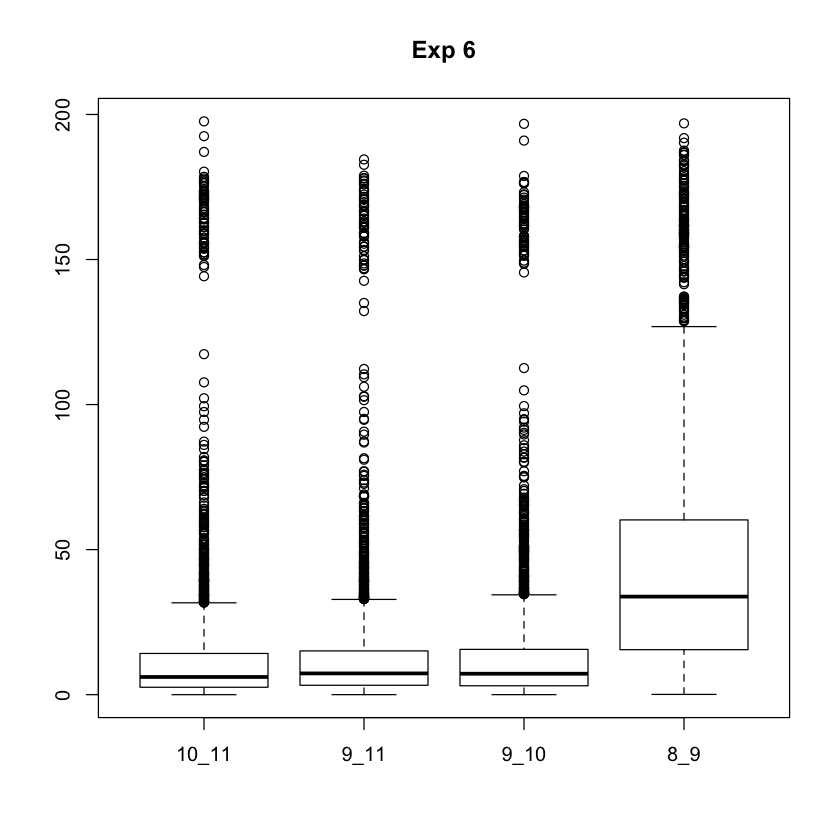

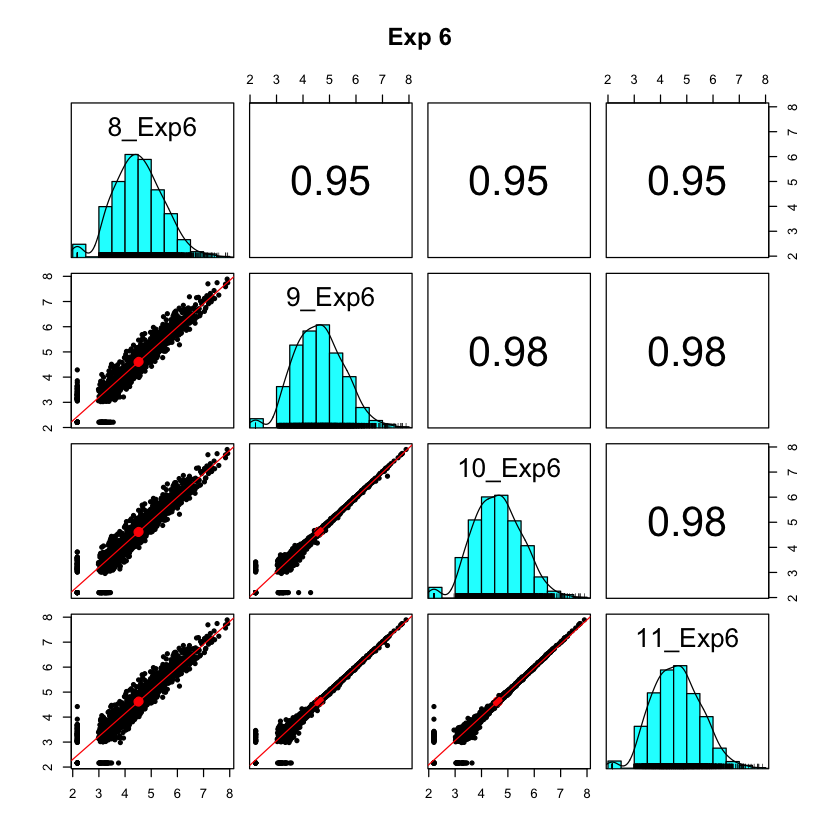

In [10]:
# Experiment 6
find_best_pair(exp6_raw, top_n, "_Exp6", "Exp 6")


Normalization Factors:  _Exp7 
 TotInt_126C_Exp7 - 0.808
 TotInt_127N_Exp7 - 0.975
 TotInt_127C_Exp7 - 1.319
 TotInt_128N_Exp7 - 0.884
 TotInt_128C_Exp7 - 1.348
 TotInt_129N_Exp7 - 1.491
 TotInt_129C_Exp7 - 0.722
 TotInt_130N_Exp7 - 1.755
 TotInt_130C_Exp7 - 0.949
 TotInt_131N_Exp7 - 0.792
 TotInt_131C_Exp7 - 0.859

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
 [1,]    0 64.19 69.78 75.30 67.30 78.19 69.08 79.72 80.57 64.39 64.82
 [2,]    0  0.00 56.07 53.32 47.87 56.44 57.10 63.62 69.62 45.32 46.38
 [3,]    0  0.00  0.00 59.04 58.61 44.98 74.17 56.45 78.93 54.20 54.09
 [4,]    0  0.00  0.00  0.00 59.30 58.45 58.18 57.74 59.79 45.55 46.15
 [5,]    0  0.00  0.00  0.00  0.00 50.34 62.19 63.34 75.14 52.80 54.34
 [6,]    0  0.00  0.00  0.00  0.00  0.00 73.32 50.15 71.33 53.49 54.76
 [7,]    0  0.00  0.00  0.00  0.00  0.00  0.00 71.94 63.69 48.97 49.45
 [8,]    0  0.00  0.00  0.00  0.00  0.00  0.00  0.00 68.58 50.76 51.00
 [9,]    0  0.00

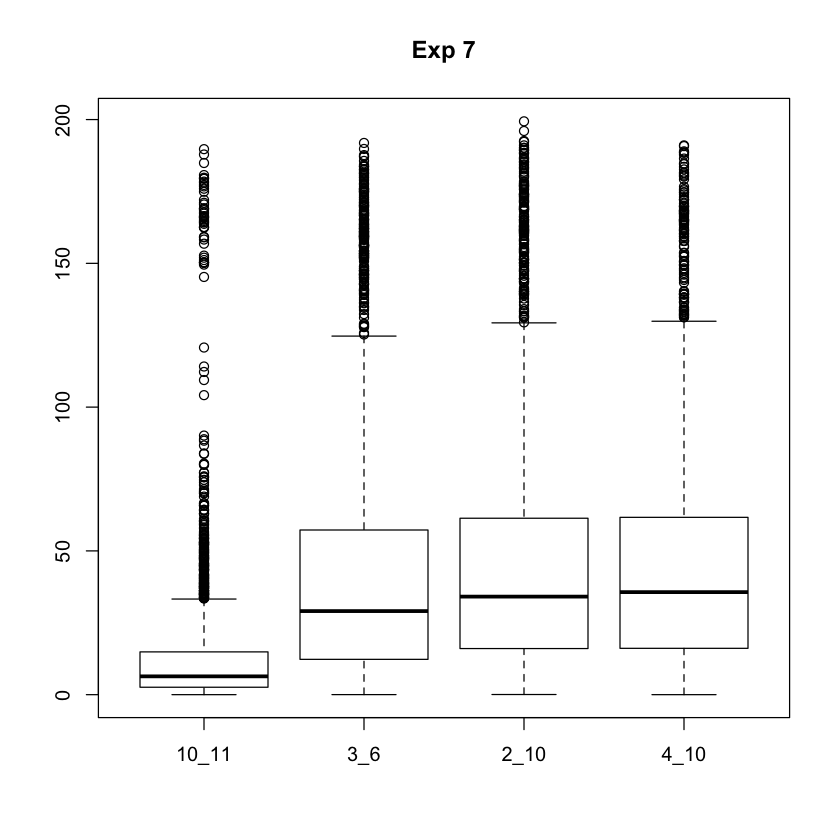

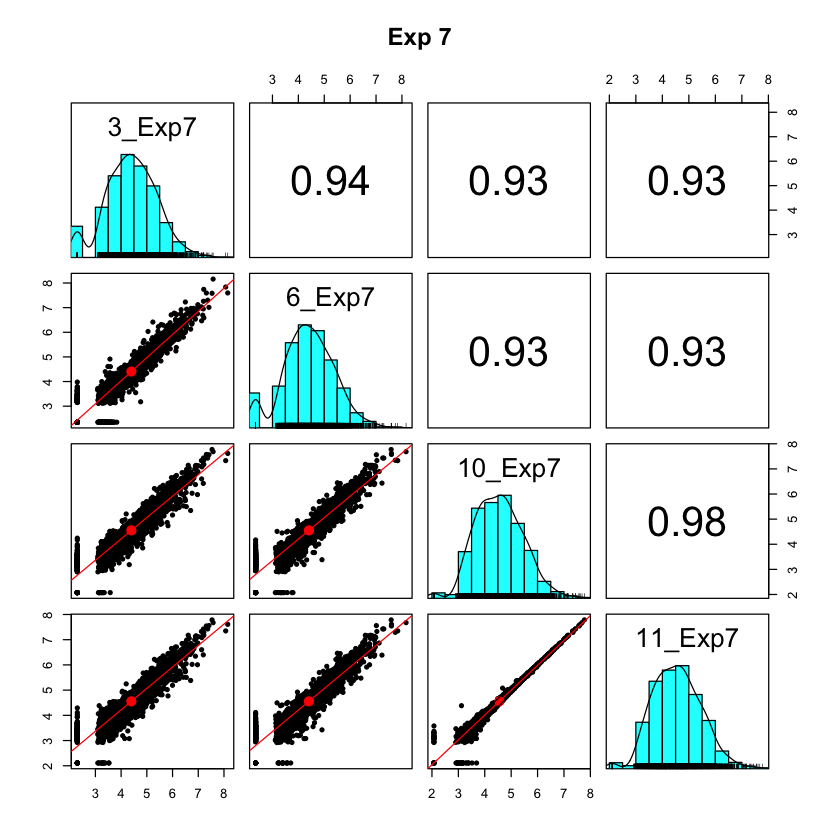

In [11]:
# and Experiment 7
find_best_pair(exp7_raw, top_n, "_Exp7", "Exp 7")

## Conclusion and comments

Channels 10 and 11 (and also 9 in three experiments) were the correct internal reference channels and that was verified here. The sample key record keeping was correct, at least for the pooled standard channels. Similarities between standard channels were excellent and consistent between experiments. We can safely perform IRS on these data using the 131-N and 131-C channels as the refrences.

In [12]:
# log the session
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2  Matrix_1.2-15   psych_1.8.10    limma_3.38.3   
 [5] forcats_0.3.0   stringr_1.3.1   dplyr_0.7.8     purrr_0.2.5    
 [9] readr_1.3.1     tidyr_0.8.2     tibble_1.4.2    ggplot2_3.1.0  
[13] tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 repr_0.18        haven_2.0.0     
 [5] lattice_0.20-38  colorspace_1.3-2 generics_0.0.2   htmltools_0.3.6 
 [9] base64enc_0.1-3  rlang_0.3.0.1    pillar_1.3.1     foreign_0.8-71  
[13] glue_1.3